In [2]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pmdarima in c:\users\ahasa\anaconda3\envs\rejse\lib\site-packages (2.0.4)



In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
 

In [4]:
data=pd.read_excel('data.xlsx')
data_update=pd.read_excel('Data(update 2023).xlsx')

In [5]:
def clean_dataframe(df):
    """
    Removes the index from the DataFrame and renames specific columns.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    # Remove the index by resetting it
    df = df.reset_index(drop=True)
    
    # Rename columns
    rename_mapping = {
        'Afgangsdato År - Måned - Dato': 'date',
        'Antal Personrejser': 'passengers'
    }
    df = df.rename(columns=rename_mapping)

    # Define the regex pattern for dd-mm-yyyy
    pattern = r'^\d{2}-\d{2}-\d{4}$'

    # Filter rows that match the pattern
    df = df[df['date'].str.match(pattern, na=False)]

    df['date']=pd.to_datetime(df['date'], dayfirst=True)
    
    return df

In [6]:
df1=clean_dataframe(data)

In [7]:
df2=clean_dataframe(data_update)

In [8]:
def append_and_update(df1, df2):
    """
    Appends `df2` to `df1` while updating the 'passengers' column for the rows
    in `df1` that have a matching 'date' in `df2`, without creating duplicate 'passengers' columns.
    
    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame (updated results).
        
    Returns:
        pd.DataFrame: The updated DataFrame with `df1`'s missing dates updated from `df2`.
    """
 
    # Merge the DataFrames on 'date' using an outer join
    merged_df = pd.merge(df1, df2, on='date', how='outer', suffixes=('_df1', '_df2'))
    
    # Update the 'passengers' column, preferring values from df2
    merged_df['passengers'] = merged_df['passengers_df2'].combine_first(merged_df['passengers_df1'])
    
    # Drop the intermediate columns
    merged_df = merged_df.drop(columns=['passengers_df1', 'passengers_df2'])
    
    return merged_df



In [9]:
df=append_and_update(df1, df2)

In [10]:
df

,date,passengers
0,2013-01-01,16013.0
1,2013-01-02,39273.0
2,2013-01-03,46267.0
3,2013-01-04,47796.0
4,2013-01-05,23165.0
...,...,...
4012,2023-12-27,361520.0
4013,2023-12-28,373478.0
4014,2023-12-29,422671.0
4015,2023-12-30,335374.0


# Model 1: SARIMA

In [ ]:
def evaluate_sarima_model(data, date_col, value_col):
    """
    Removes rows with dates before 1st January 2021, performs an 80:20 train-test split,
    fits a SARIMA(1,1,0)(1,1,1)[7] model, evaluates it using MAE, RMSE, MASE, and MAPE,
    and plots the actual vs forecasted values.
    
    Args:
        data (pd.DataFrame): Input DataFrame with a date column and a value column.
        date_col (str): Name of the date column.
        value_col (str): Name of the column containing the time series values.

    Returns:
        dict: A dictionary with MAE, RMSE, MASE, and MAPE metrics.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])
    
    # Filter rows with dates from 1st January 2021 onwards
    data = data[data[date_col] >= '2021-01-01'].sort_values(by=date_col)
    
    # Ensure the time series is indexed by the date column
    data.set_index(date_col, inplace=True)
    
    # Extract the series
    series = data[value_col]
    
    # Train-test split (80:20)
    split_index = int(len(series) * 0.8)
    train, test = series[:split_index], series[split_index:]
    
    # Fit the SARIMA(1,1,0)(1,1,1)[7] model
    sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    sarima_fit = sarima_model.fit(disp=False)
    
    # Forecast for the test set period
    forecast = sarima_fit.forecast(steps=len(test))
    
    # Compute evaluation metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    # Mean Absolute Scaled Error (MASE)
    naive_forecast = train.diff().dropna()  # One-step naive forecast
    mase = mae / mean_absolute_error(train[1:], naive_forecast)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    
    # Plot the actual vs forecasted values
    plt.figure(figsize=(10, 4))
    #plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test (Actual)', color='orange')
    plt.plot(test.index, forecast, label='Forecast', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Actual vs Forecasted: {value_col}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MASE': mase,
        'MAPE': mape
    }


c:\Users\ahasa\anaconda3\envs\rejse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ahasa\anaconda3\envs\rejse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ahasa\anaconda3\envs\rejse\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


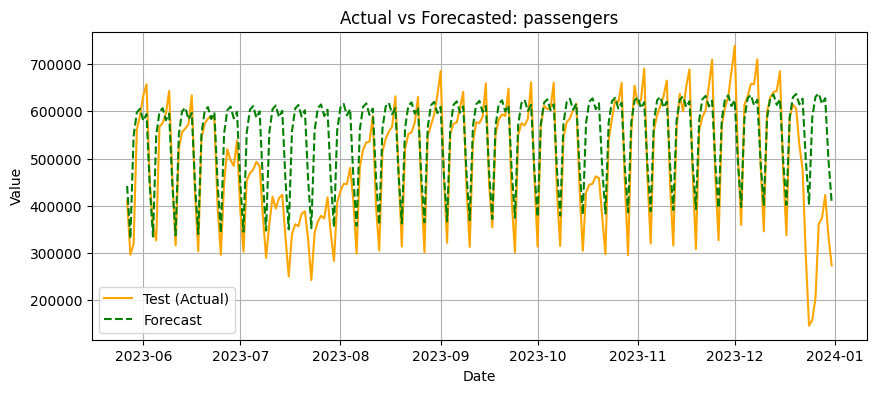

{'MAE': 71193.5978035847, 'RMSE': 101776.439195234, 'MASE': 0.16231628649343607, 'MAPE': 18.980568869652142}


In [12]:
metrics = evaluate_sarima_model(df, date_col='date', value_col='passengers')
print(metrics)

# Model 2: Prophet

In [163]:
def evaluate_prophet_model(data, date_col, value_col):
    """
    Removes rows with dates before 1st January 2021, performs an 80:20 train-test split,
    fits a Prophet model, and evaluates it using MAE, RMSE, MASE, and MAPE.

    Args:
        data (pd.DataFrame): Input DataFrame with a date column and a value column.
        date_col (str): Name of the date column.
        value_col (str): Name of the column containing the time series values.

    Returns:
        dict: A dictionary with MAE, RMSE, MASE, and MAPE metrics.
    """
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])
    
    # Filter rows with dates from 1st January 2021 onwards
    data = data[data[date_col] >= '2021-01-01'].sort_values(by=date_col)
    
    # Rename the columns to fit Prophet's expectations
    data = data.rename(columns={date_col: 'ds', value_col: 'y'})
    
    # Ensure the time series is indexed by the date column
    data.set_index('ds', inplace=True)
    
    # Extract the series
    series = data['y']
    
    # Train-test split (80:20)
    split_index = int(len(series) * 0.8)
    train, test = series[:split_index], series[split_index:]
    
    # Prepare the training data for Prophet
    train_prophet = train.reset_index()[['ds', 'y']]
    
    # Fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_prophet)
    
    # Create a dataframe with future dates for forecasting
    periods=len(test)
    future = prophet_model.make_future_dataframe(periods, freq='D')
    
    # Forecast the test set period
    forecast = prophet_model.predict(future)
    
    # Extract the forecasted values for the test period
    forecast_values = forecast['yhat'][-len(test):].values
    
    # Compute evaluation metrics
    mae = mean_absolute_error(test, forecast_values)
    rmse = np.sqrt(mean_squared_error(test, forecast_values))
    
    # Mean Absolute Scaled Error (MASE)
    naive_forecast = train.diff().dropna()  # One-step naive forecast
    mase = mae / mean_absolute_error(train[1:], naive_forecast)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((test - forecast_values) / test)) * 100
    
    # Plot the actual vs forecasted values
    plt.figure(figsize=(10, 6))
    #plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test (Actual)', color='orange')
    plt.plot(test.index, forecast_values, label='Forecast', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Actual vs Forecasted: {value_col} with Prophet')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MASE': mase,
        'MAPE': mape
    }


13:15:41 - cmdstanpy - INFO - Chain [1] start processing
13:15:41 - cmdstanpy - INFO - Chain [1] done processing


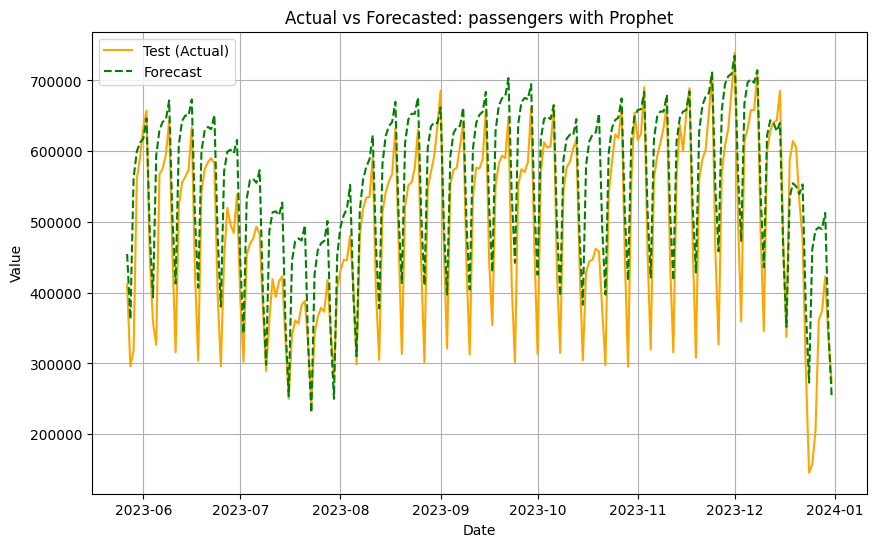

{'MAE': np.float64(66946.49893137322), 'RMSE': np.float64(81553.24642742226), 'MASE': np.float64(0.1526332062927454), 'MAPE': np.float64(16.511674126745195)}


In [164]:
metrics = evaluate_prophet_model(df, date_col='date', value_col='passengers')
print(metrics)

# LSTM 2

In [224]:
%pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.68.0-cp310-cp310-win_amd64.whl.metadata (4.0 kB)
  Using cached ml_dtypes-0.4.1-cp310-cp310-win_amd64.whl.metadata (20 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/390.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/390.0 MB 6.1 MB/s eta 0:01:04
   ---

  You can safely remove it manually.
  You can safely remove it manually.


In [228]:
%pip install keras-tuner
import keras_tuner 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping

def evaluate_bidirectional_lstm(data, date_col, value_col, look_back=100, epochs=100, batch_size=32):
    """
    Evaluates a Bidirectional LSTM model with improved preprocessing and a larger look-back window.

    Args:
        data (pd.DataFrame): Input DataFrame with a date column and a value column.
        date_col (str): Name of the date column.
        value_col (str): Name of the column containing the time series values.
        look_back (int): Number of past observations to use for prediction.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        dict: A dictionary with MAE, RMSE, MASE, MAPE metrics and model parameters.
        model: The trained Bidirectional LSTM model.
    """
    from sklearn.preprocessing import MinMaxScaler
    
    # Ensure the date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])
    
    # Filter rows with dates from 1st January 2021 onwards
    #data = data[data[date_col] >= '2021-01-01'].sort_values(by=date_col)
    
    # Sort data and reset index
    data = data.sort_values(by=date_col).reset_index(drop=True)
    
    # Scale the data for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[value_col]])
    
    # Function to create sliding windows
    def create_sequences(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        return np.array(X), np.array(y)
    
    # Create sequences for supervised learning
    X, y = create_sequences(scaled_data, look_back)
    
    # Train-test split (80:20)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Reshape for LSTM (samples, timesteps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Build Bidirectional LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    
    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
    
    # Forecast
    y_pred = model.predict(X_test).flatten()
    
    # Inverse scale the predictions and actual values
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Mean Absolute Scaled Error (MASE)
    naive_forecast = np.diff(scaled_data.flatten())
    mase = mae / mean_absolute_error(scaled_data[1:], naive_forecast)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Plot the actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(data[date_col].iloc[-len(y_test):], y_test, label='Test (Actual)', color='orange')
    plt.plot(data[date_col].iloc[-len(y_test):], y_pred, label='Forecast', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Actual vs Forecasted: {value_col} with Bidirectional LSTM')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Return evaluation metrics and model
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MASE': mase,
        'MAPE': mape,
        'Parameters': model.count_params(),
    }, model


c:\Users\ahasa\anaconda3\envs\rejse\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 406ms/step - loss: 0.0217 - val_loss: 0.0210
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 297ms/step - loss: 0.0114 - val_loss: 0.0210
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 59s 482ms/step - loss: 0.0115 - val_loss: 0.0222
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 322ms/step - loss: 0.0111 - val_loss: 0.0187
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - loss: 0.0100 - val_loss: 0.0158
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - loss: 0.0069 - val_loss: 0.0104
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - loss: 0.0057 - val_loss: 0.0113
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - loss: 0.0053 - val_loss: 0.0079
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - loss: 0.0050 - val_loss: 0.0073
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 12/100
98/98 ━━━━━━━━━━━

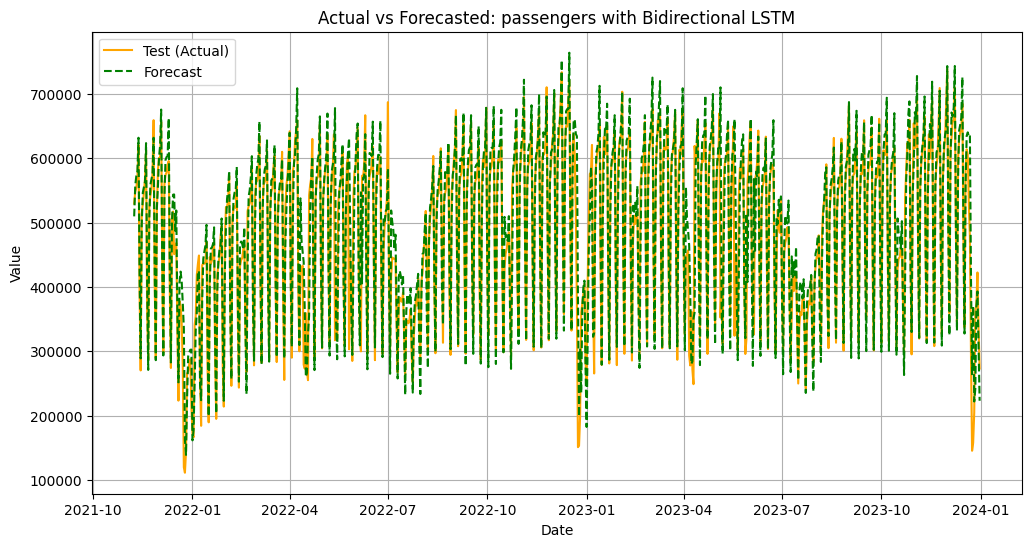

({'MAE': np.float64(29858.52786192602),
  'RMSE': np.float64(50109.0747071608),
  'MASE': np.float64(77235.65496785573),
  'MAPE': np.float64(7.521306594852573),
  'Parameters': 297601},
 <Sequential name=sequential_3, built=True>)

In [255]:
evaluate_bidirectional_lstm(df, date_col='date', value_col='passengers')